In [1]:
!pip install -q keras

In [5]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=502746b26aaa9a6d2c7461aae45917b4dac17e3d53a0322738ef1de80a0ebfdc
  Stored in directory: /tmp/local/12220201/pip-ephem-wheel-cache-vv38de1q/wheels/4b/a5/2d/4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils

[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import keras

2023-04-27 17:59:40.239586: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 17:59:41.327802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/software/CUDA/12.0.0/nvvm/lib64:/opt/software/CUDA/12.0.0/extras/CUPTI/lib64:/opt/software/CUDA/12.0.0/lib
2023-04-27 17:59:41.327855: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils 
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
pwd

'/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main'

In [18]:

os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI")
os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/glioma_tumor")
os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/meningioma_tumor")
os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/no_tumor")
os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/pituitary_tumor")

In [19]:
os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data")
os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/glioma_tumor")
os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/meningioma_tumor")
os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/no_tumor")
os.mkdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/pituitary_tumor")

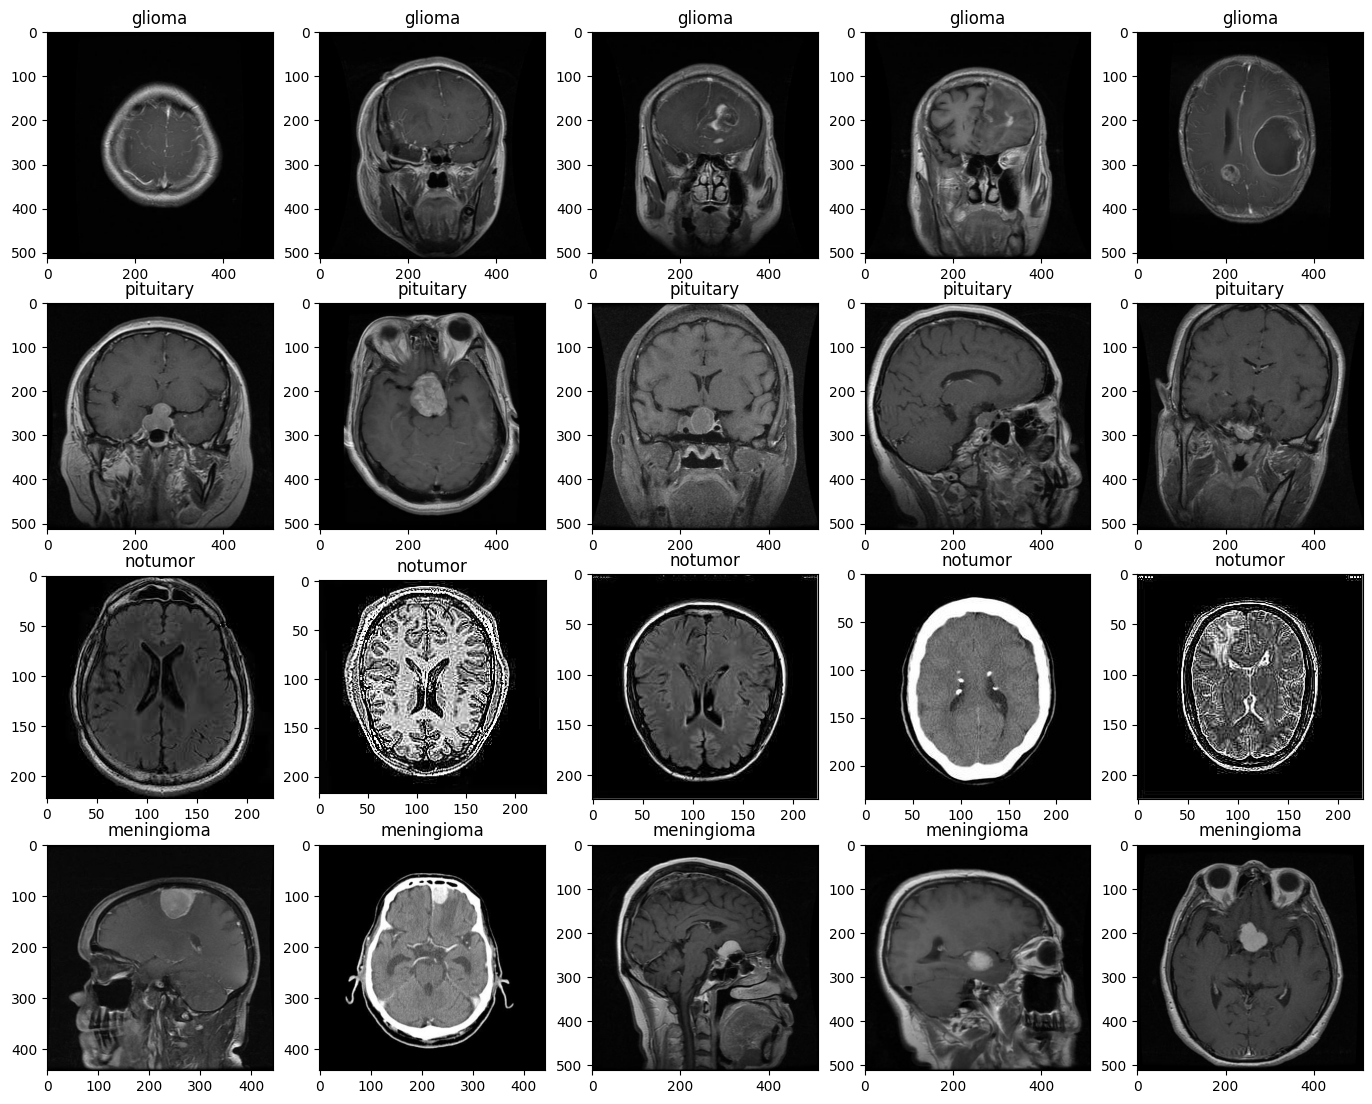

In [20]:
train_dir = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/Classification/Training/"
test_dir = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/Classification/Testing/"
classes = os.listdir("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/Classification/Training/")
files_path_dict = {}
for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir + c + '/' + x, os.listdir(train_dir + c)))


plt.figure(figsize = (17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:6]

  for i in range(1, 6):
    index += 1
    plt.subplot(5, 5, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [5]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

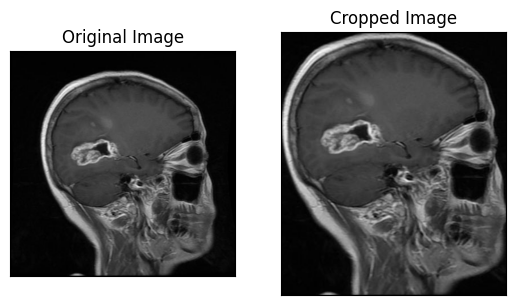

In [6]:
example_img = cv2.imread("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/Classification/Training/glioma/Tr-gl_1213.jpg")
copped_image = crop_image(example_img, plot=True)

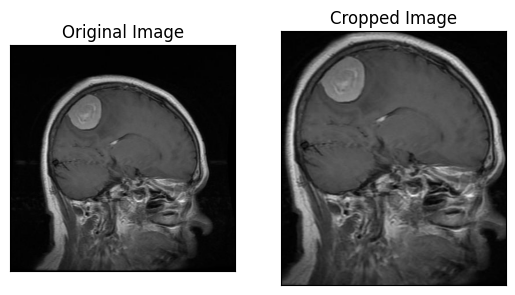

In [24]:
example_img1 = cv2.imread("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/Classification/Training/meningioma/Tr-me_1209.jpg")
copped_image1 = crop_image(example_img1, plot=True)

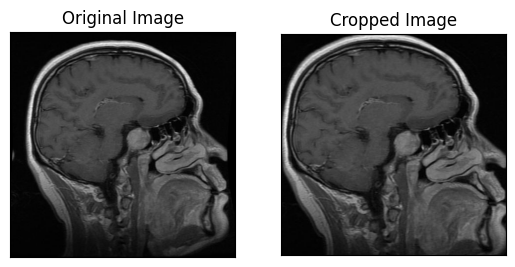

In [25]:
example_img2 = cv2.imread("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/Classification/Training/pituitary/Tr-pi_0893.jpg")
copped_image2 = crop_image(example_img2, plot=True)

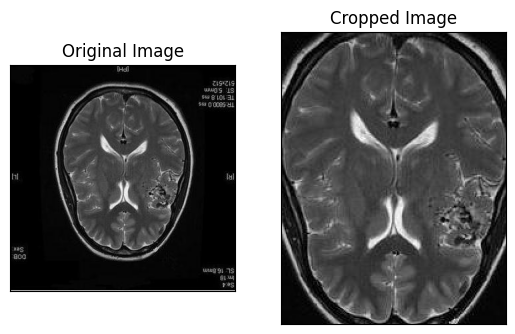

In [26]:
example_img3 = cv2.imread("/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/Classification/Training/notumor/Tr-no_0612.jpg")
copped_image3 = crop_image(example_img3, plot=True)

In [27]:
pwd


'/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main'

In [21]:
glioma = train_dir + "glioma"
meningioma = train_dir + "meningioma"
no_tumor = train_dir + "notumor"
pituitary = train_dir + "pituitary"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 1457/1457 [00:36<00:00, 39.74it/s]


In [24]:
test_glioma = test_dir + "glioma"
test_meningioma = test_dir + "meningioma"
test_no_tumor = test_dir + "notumor"
test_pituitary = test_dir + "pituitary"

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 300/300 [00:07<00:00, 37.71it/s]


In [25]:
# Use Image Data Generator to perform this task.
datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/',target_size = (224, 224), batch_size = 32,class_mode = 'categorical',subset = 'training')

valid_data = datagen.flow_from_directory('/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Crop-Brain-MRI/',target_size = (224, 224),batch_size = 32,class_mode = 'categorical',subset = 'validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/',target_size = (224, 224),class_mode = 'categorical',)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [9]:

print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


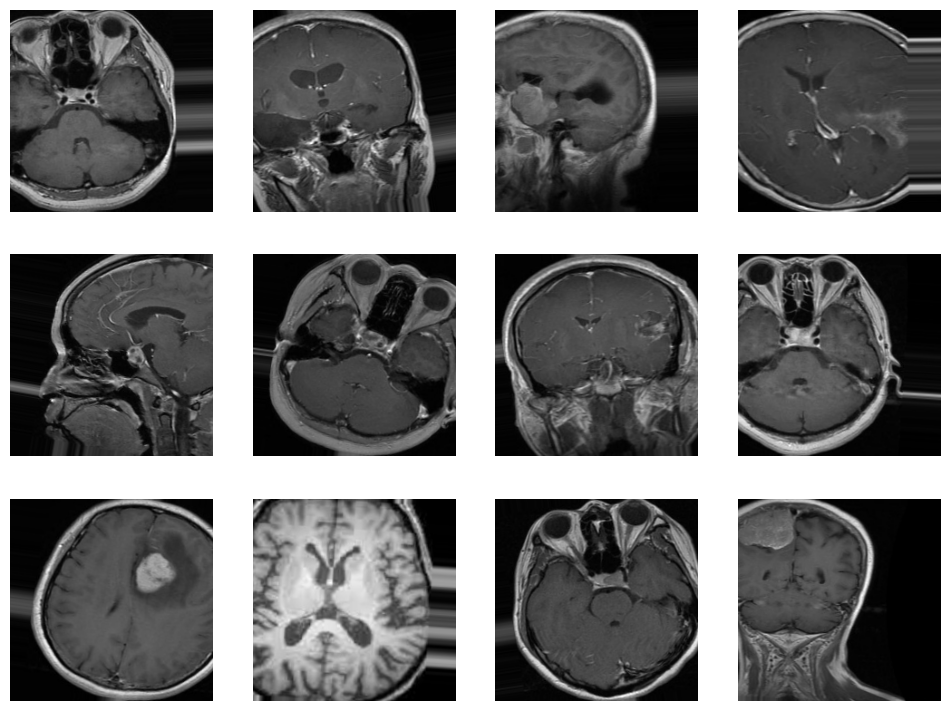

In [26]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize = (12,9))
for i in range (12):
  plt.subplot(3, 4, i + 1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

In [37]:
# Build the Model
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs = effnet.input, outputs = model)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_7 (Normalization  (None, 224, 224, 3)  7          ['rescaling_7[0][0]']            
 )                                                                                                
                                                                                            

In [38]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
earlystopping = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [39]:
print(tf.__version__)

2.9.0


In [40]:
# Train the model
history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/7
143/143 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.7948
Epoch 1: val_accuracy improved from -inf to 0.83699, saving model to model.h5
143/143 [==============================] - 269s 2s/step - loss: 0.5533 - accuracy: 0.7948 - val_loss: 0.3985 - val_accuracy: 0.8370
Epoch 2/7
143/143 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9346
Epoch 2: val_accuracy improved from 0.83699 to 0.86152, saving model to model.h5
143/143 [==============================] - 208s 1s/step - loss: 0.1852 - accuracy: 0.9346 - val_loss: 0.3485 - val_accuracy: 0.8615
Epoch 3/7
143/143 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9622
Epoch 3: val_accuracy improved from 0.86152 to 0.92726, saving model to model.h5
143/143 [==============================] - 207s 1s/step - loss: 0.1106 - accuracy: 0.9622 - val_loss: 0.1986 - val_accuracy: 0.9273
Epoch 4/7
143/143 [==============================] - ETA: 0s - loss: 0.0665 - a

#### Hyper parameter tuning


From the above default values, we can see that I was able to achieve an accuracy of 98.99. I tried to tune the hyperparameters in several ways and finally found that the below way actually for hours and didnt even display one single epoch. So as a part of my app, I'm going to use the best saved model from the previous epochs.

In [31]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(lr=0.001, batch_size=16, dropout_rate=0.2, units=2):
    effnet1 = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    model1 = effnet1.output
    model1 = GlobalAveragePooling2D()(model1)
    model1 = Dropout(dropout_rate)(model1)
    model1 = Dense(units, activation="softmax")(model1)
    model1 = Model(inputs=effnet1.input, outputs=model1)
    model1.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model1

model = KerasClassifier(build_fn=create_model)

param_grid = {
    'lr': [0.001, 0.01, 0.1],  # Learning rate
    'batch_size': [16, 32, 64],  # Batch size
    'dropout_rate': [0.2, 0.5, 0.8],  # Dropout rate
    'units': [2, 4, 8],  # Number of units in the dense layer
}

/tmp/local/12586007/ipykernel_47197/70208798.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


In [34]:
grid = GridSearchCV(model, param_grid, cv=5)
grid_result = grid.fit(train_data, validation_data=valid_data)

In [ ]:
print("Best Hyperparameters: ", grid.best_params_)
print("Best Accuracy: ", grid.best_score_)

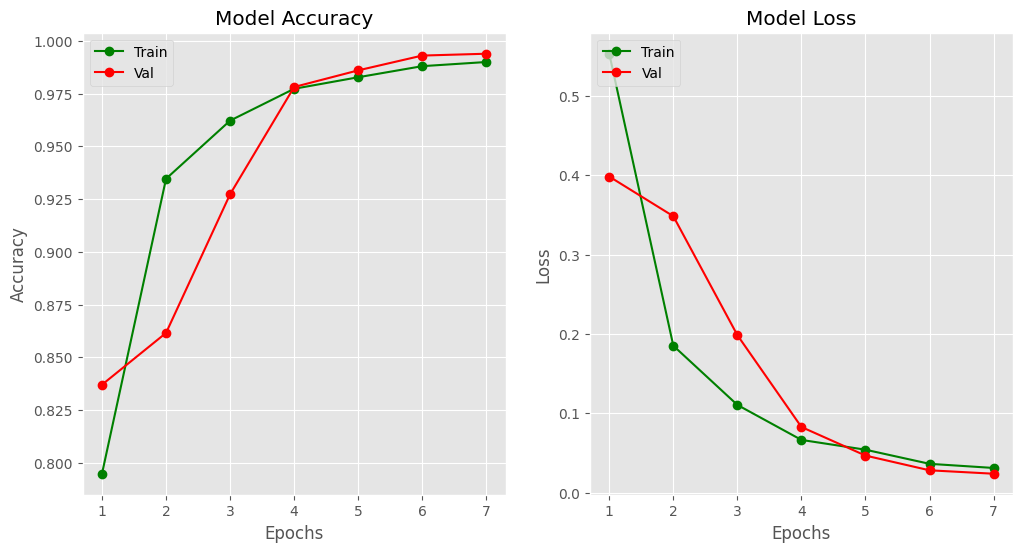

In [41]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))
epochs = range(1, 8)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

In [42]:
pwd

'/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main'

### Testing on test data

In [47]:

# Load the saved model
model = load_model('model.h5')

# Define the test data directories
test_dirs = ['/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/glioma_tumor',
             '/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/meningioma_tumor',
             '/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/no_tumor',
             '/mnt/ufs18/home-230/mylakuma/Brain-Tumor-Multiclass-Classification-and-Segmentation-using-Deep-Learning-main/contents/Test-Data/pituitary_tumor']

# Define the labels and their corresponding class indices
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
class_indices = {label: i for i, label in enumerate(labels)}

# Initialize the variables for the true labels and predicted labels
y_true = []
y_pred = []

# Loop through each file in the test directories
for test_dir in test_dirs:
    for file in os.listdir(test_dir):
        # Load the image and preprocess it
        img = image.load_img(os.path.join(test_dir, file), target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Make a prediction using the saved model
        pred = model.predict(x)[0]

        # Get the true label from the directory name and append it to y_true
        true_label = test_dir.split('/')[-1]
        y_true.append(class_indices[true_label])

        # Get the predicted label and append it to y_pred
        pred_label = labels[np.argmax(pred)]
        y_pred.append(class_indices[pred_label])

# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


1/1 [==============================] - 0s 60ms/step
[[ 57 122  75  46]
 [ 47 104 129  26]
 [ 72 115 189  29]
 [ 54 109 105  32]]


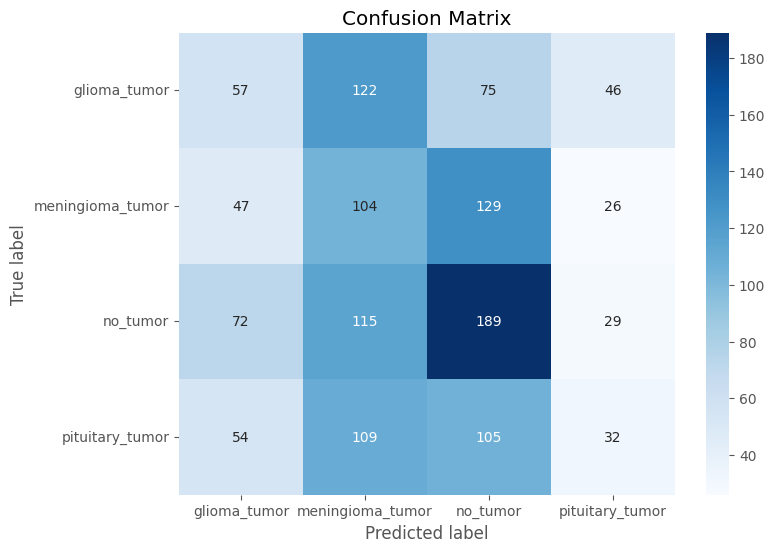

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the class labels
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Create the confusion matrix
conf_matrix = [[57, 122, 75, 46], [47, 104, 129, 26], [72, 115, 189, 29], [54, 109, 105, 32]]

np.set_printoptions(suppress=True)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt ='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

plt.show()
